In [2]:
import sys
sys.path.append('/u/ajagadish/ermi/categorisation/')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import json
from collections import Counter, defaultdict
from wordcloud import WordCloud
from mycolorpy import colorlist as mcp
import math
FONTSIZE=20
SYS_PATH = '/u/ajagadish/ermi' #'/raven/u/ajagadish/vanilla-llama/'

In [31]:
def world_cloud(file_name, path='/u/ajagadish/vanilla-llama/categorisation/data/tasklabels', feature_names=True, pairs=False, top_labels=50):

    df = pd.read_csv(f'{path}/{file_name}.csv')
    df.feature_names = df['feature_names'].apply(lambda x: eval(x))
    df.category_names = df['category_names'].apply(lambda x: eval(x))
    
    def to_lower(ff):
        return [x.lower() for x in ff]
    
    df.feature_names = df['feature_names'].apply(lambda x: to_lower(x))
    df.category_names = df['category_names'].apply(lambda x: to_lower(x))

    # name of the column containing the feature names
    column_name = 'feature_names' if feature_names else 'category_names'
    # count of number of times a type of features occurs
    list_counts = Counter([tuple(features) for features in df[column_name]] if pairs else np.stack(df[column_name].values).reshape(-1))

    # sort the Counter by counts in descending order
    sorted_list_counts = sorted(list_counts.items(), key=lambda x: x[1], reverse=True)

    # extract the counts and names for the top 50 labels
    task_labels = np.array([task_label[0] for task_label in sorted_list_counts[:top_labels]])
    label_counts= np.array([task_label[1] for task_label in sorted_list_counts[:top_labels]])
    label_names = ['-'.join(task_labels[idx]) for idx in range(len(task_labels))] if pairs else task_labels

    # make a dict with task labels and counts
    word_freq = {}
    for idx in range(len(label_names)):
        word_freq[label_names[idx]] = label_counts[idx]

    # generate word cloud
    # wordcloud = WordCloud(width=800, height=400, max_words=50, background_color='white').generate_from_frequencies(word_freq)
    wordcloud = WordCloud(width = 1300, height = 700, background_color='white',max_font_size = 100, collocations=False, colormap='inferno', prefer_horizontal=1).generate_from_frequencies(word_freq)
    plt.figure(figsize=(13, 7), dpi=1000)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    wordcloud.to_file(f'{SYS_PATH}/figures/wordcloud_{column_name}_paired={pairs}_top{top_labels}.png')

In [12]:
def plot_frequency_tasklabels(file_name, path='/u/ajagadish/vanilla-llama/categorisation/data/tasklabels', feature_names=True, pairs=True, top_labels=50):

    df = pd.read_csv(f'{path}/{file_name}.csv')
    df.feature_names = df['feature_names'].apply(lambda x: eval(x))
    df.category_names = df['category_names'].apply(lambda x: eval(x))
    
    def to_lower(ff):
        return [x.lower() for x in ff]
    
    df.feature_names = df['feature_names'].apply(lambda x: to_lower(x))
    df.category_names = df['category_names'].apply(lambda x: to_lower(x))

    # name of the column containing the feature names
    column_name = 'feature_names' if feature_names else 'category_names'
    # count of number of times a type of features occurs
    list_counts = Counter([tuple(features) for features in df[column_name]] if pairs else np.stack(df[column_name].values).reshape(-1))

    # sort the Counter by counts in descending order
    sorted_list_counts = sorted(list_counts.items(), key=lambda x: x[1], reverse=True)

    # extract the counts and names for the top 50 labels
    task_labels = np.array([task_label[0] for task_label in sorted_list_counts[:top_labels]])
    label_counts= np.array([task_label[1] for task_label in sorted_list_counts[:top_labels]])
    label_names = ['-'.join(task_labels[idx]) for idx in range(len(task_labels))] if pairs else task_labels

    # plot the bars of labels and counts
    f, ax = plt.subplots(1, 1, figsize=(10,10))
    ax.bar(label_names, label_counts)
    plt.xticks(label_names, label_names, rotation=90, fontsize=FONTSIZE-6.5)
    plt.yticks(fontsize=FONTSIZE-6)
    ax.set_xlabel('Feature Names' if feature_names else 'Category Names', fontsize=FONTSIZE)
    ax.set_ylabel('Counts', fontsize=FONTSIZE)
    ax.set_title(f'Top {top_labels} Tasks', fontsize=FONTSIZE)
    sns.despine()
    f.tight_layout()
    plt.show()
    
    f.savefig(f'{SYS_PATH}/figures/frequency_plot_tasklabels_{column_name}_paired={pairs}_top{top_labels}.png', bbox_inches='tight', dpi=300)


In [5]:
def model_simulations_smith1998(plot='main'):

    models = ['smith1998', 'ermi', 'synthetic', 'llm'] if plot == 'main' else ['smith1998', 'ermi', 'syntheticnonlinear']#'human'
    f, ax = plt.subplots(1, len(models), figsize=(5*len(models),5))
    colors = ['#173b4f', '#748995']##5d7684']
    # colors = ['#173b4f', '#4d6a75', '#5d7684', '#748995','#4d6a75', '#0d2c3d', '#a2c0a9', '#2f4a5a', '#8b9da7']
    num_blocks = None
    for idx, model in enumerate(models):
        if model=='smith1998':
       
            with open(f'{SYS_PATH}/categorisation/data/human/{model}.json') as file:
                human_data = json.load(file)

            # human data procesing
            fits_gcm, fits_pm = {}, {}
            mses_gcm = np.array(human_data['exemplar']['y'])
            mses_pm = np.array(human_data['prototype']['y'])
            # std error of mean across participants set to 0.
            stds_gcm = np.zeros_like(mses_gcm)
            stds_pm = np.zeros_like(mses_pm)
            # unsquezze to add a dimension for participants
            mses_gcm = np.expand_dims(mses_gcm, axis=0)
            mses_pm = np.expand_dims(mses_pm, axis=0)
    
        else:

            fits_gcm = np.load(f'{SYS_PATH}/categorisation/data/fitted_simulation/devraj2022_gcm_runs=1_iters=1_blocks=11_loss=mse_transfer_model={model}.npz')
            fits_pm = np.load(f'{SYS_PATH}/categorisation/data/fitted_simulation/devraj2022_pm_runs=1_iters=1_blocks=11_loss=mse_transfer_model={model}.npz')
            
            # load mses
            mses_gcm = fits_gcm['lls']
            mses_pm = fits_pm['lls']
            # mean mses across participants: mses are of shape (n_runs=1, n_participants, n_conditions=1, n_blocks)
            mses_gcm = np.squeeze(mses_gcm)
            mses_pm = np.squeeze(mses_pm)
            # std error of mean across participants
            stds_gcm = np.std(mses_gcm, axis=0)/np.sqrt(len(mses_gcm)-1)
            stds_pm = np.std(mses_pm, axis=0)/np.sqrt(len(mses_pm)-1)
             
        # keep only the first num_blocks (useful when using smith1998 data)
        num_blocks = 10 if 'smith1998' in models else 33
        mses_gcm = mses_gcm[:, :num_blocks]
        mses_pm = mses_pm[:, :num_blocks]
        stds_gcm = stds_gcm[:num_blocks]
        stds_pm = stds_pm[:num_blocks]
    
        # plot mean mses across participants for each trial segment for both models
        sns.lineplot(x=np.arange(mses_pm.shape[1])+1, y=np.mean(mses_pm, axis=0), ax=ax[idx], color=colors[0], label='Protype-based', lw=3)
        sns.lineplot(x=np.arange(mses_gcm.shape[1])+1, y=np.mean(mses_gcm, axis=0), ax=ax[idx], color=colors[1], label='Exemplar-based', lw=3)
        # add standard error of mean as error bars
        ax[idx].fill_between(np.arange(mses_pm.shape[1])+1, np.mean(mses_pm, axis=0)-stds_pm, np.mean(mses_pm, axis=0)+stds_pm, alpha=0.2, color=colors[0])
        ax[idx].fill_between(np.arange(mses_gcm.shape[1])+1, np.mean(mses_gcm, axis=0)-stds_gcm, np.mean(mses_gcm, axis=0)+stds_gcm, alpha=0.2, color=colors[1])
        ax[idx].set_ylim([-0.05, 3.])
        ax[idx].set_xticks(np.arange(mses_gcm.shape[1])+1)
        # set y ticks font size
        ax[idx].tick_params(axis='y', labelsize=FONTSIZE-2)
        ax[idx].set_xticklabels(np.arange(mses_gcm.shape[1])+1,fontsize=FONTSIZE-2)
        if idx==0:
            ax[idx].set_ylabel('Error', fontsize=FONTSIZE)
            # remove bounding box around the legend
            ax[idx].legend(frameon=False, fontsize=FONTSIZE-2)
            ax[idx].set_title('Human', fontsize=FONTSIZE)
            ax[idx].set_xlabel('Block', fontsize=FONTSIZE) #Trial segment
        elif idx==1:
            ax[idx].set_title('ERMI', fontsize=FONTSIZE)
        elif idx==2:
            ax[idx].set_title('MI' if plot == "main" else 'PFN', fontsize=FONTSIZE)
        elif idx==3:
            ax[idx].set_title('LLM' if plot == "main" else 'PFN', fontsize=FONTSIZE)
            
        
        if idx!=0:
            # remove legend
            ax[idx].legend([], frameon=False, fontsize=FONTSIZE-2)
        
    sns.despine()
    f.tight_layout()
    plt.show()
    f.savefig(f'{SYS_PATH}/figures/model_simulations_smith1998.png', bbox_inches='tight', dpi=300)


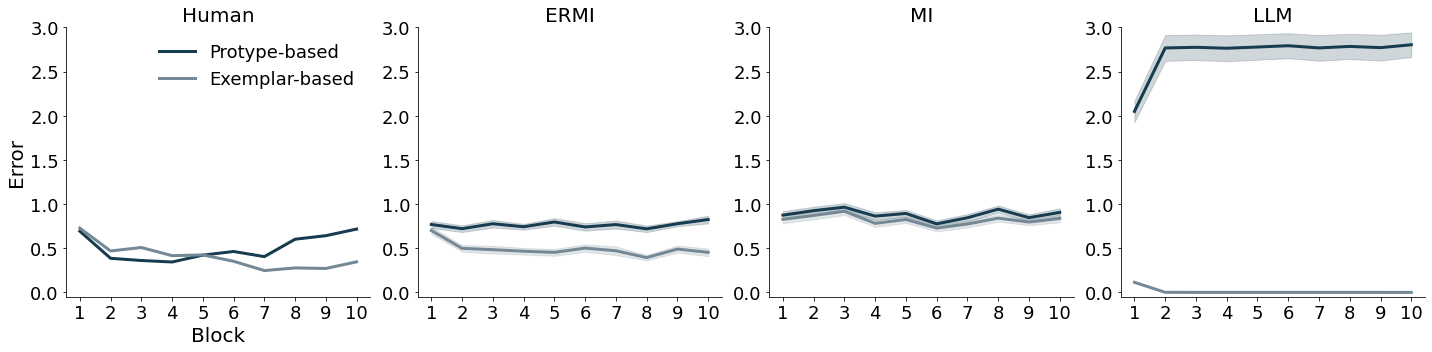

In [6]:
model_simulations_smith1998('main')

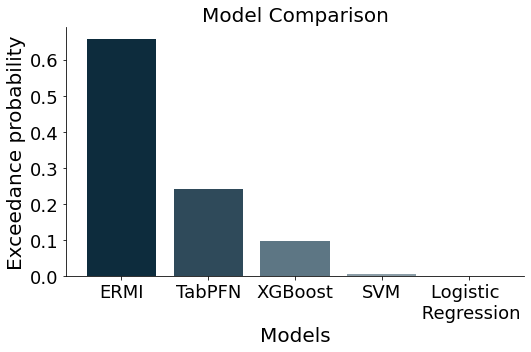

In [3]:
from groupBMC.groupBMC import GroupBMC
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
mean_performance = pd.read_csv('../categorisation/data/openMLCC18/mean_performance.csv')
LogEvidence = mean_performance.values[:, 1:-1].T
result = GroupBMC(LogEvidence).get_result()

models = list(mean_performance.columns.values[1:-1])
models[0] = 'Logistic \n Regression'
# rename models for plot
colors = ['#173b4f', '#8b9da7', '#5d7684', '#2f4a5a', '#0d2c3d', '#4d6a75', '#748995', '#a2c0a9', '#c4d9c2']
# sort result in descending order
sort_order = np.argsort(result.exceedance_probability)[::-1]
result.exceedance_probability = result.exceedance_probability[sort_order]
models = np.array(models)[sort_order]
colors = np.array(colors)[sort_order]
FIGSIZE=(7.5,5)
FONTSIZE=20
horizontal = False
f, ax = plt.subplots(1, 1, figsize=FIGSIZE)
if horizontal:
    # composed
    ax.barh(np.arange(len(models)), result.exceedance_probability, align='center', color=colors[:len(models)], height=0.6)#, hatch='//', label='Compostional Subtask')
    # plt.legend(fontsize=FONTSIZE-4, frameon=False)
    ax.set_ylabel('Models', fontsize=FONTSIZE)
    # ax.set_xlim(0, 0.7)
    ax.set_xlabel('Exceedance probability', fontsize=FONTSIZE) 
    plt.yticks(ticks=np.arange(len(models)), labels=models, fontsize=FONTSIZE-3.)
    # ax.set_xticks(np.arange(0, result.exceedance_probability.max(), 0.1))
    plt.xticks(fontsize=FONTSIZE-4)
else:
    # composed
    bar_positions = np.arange(len(result.exceedance_probability))*0.5
    ax.bar(bar_positions, result.exceedance_probability, color=colors, width=0.4)
    # plt.legend(fontsize=FONTSIZE, frameon=False)
    ax.set_xlabel('Models', fontsize=FONTSIZE)
    # ax.set_ylim(0, 0.7)
    ax.set_ylabel('Exceedance probability', fontsize=FONTSIZE) 
    ax.set_xticks(bar_positions)  # Set x-tick positions to bar_positions
    ax.set_xticklabels(models, fontsize=FONTSIZE-2)  # Assign category names to x-tick labels
    plt.yticks(fontsize=FONTSIZE-2)

ax.set_title(f'Model Comparison', fontsize=FONTSIZE)
sns.despine()
f.tight_layout()
# f.savefig(f'{SYS_PATH}/figures/exceedance_probability_{task_name}.svg', bbox_inches='tight', dpi=300)
plt.show()

In [10]:
result.protected_exceedance_probability

array([0.19968828, 0.19969535, 0.19984014, 0.20006441, 0.20071182])

In [5]:
result.exceedance_probability, models

(array([6.56656100e-01, 2.41321635e-01, 9.74459110e-02, 4.55685213e-03,
        1.95017171e-05]),
 array(['ERMI', 'TabPFN', 'XGBoost', 'SVM', 'Logistic \n Regression'],
       dtype='<U21'))

In [68]:
len(mean_performance)

23

## six rules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
datas = pd.read_csv('../categorisation/data/llm/shepard1961_llm_choices_match_ermi.csv')
categories = {'j': 'A', 'f': 'B'}
datas['human_category']=datas['choice'].map(categories)

/u/ajagadish/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning: Columns (14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [28]:
num_participants = 94
num_rules = 6
num_block = 6
correct = np.ones((num_rules, num_participants, 96))
human_correct = np.ones((num_rules, num_participants, 96))
block_errors = np.ones((num_rules, num_block))

datas = pd.read_csv('../categorisation/data/llm/shepard1961_llm_choices_match_ermi.csv')
categories = {'j': 'A', 'f': 'B'}
datas['human_category']=datas['choice'].map(categories)


for participant_id  in range(num_participants):#= 4
    for cond in datas.condition.unique(): #datas.condition.nunique()):
        if cond<=4:
            load_data = pd.read_csv('../categorisation/data/llm/badham2017deficits_llm_choicesmatch_ermi.csv')
        else:
            load_data = pd.read_csv('../categorisation/data/llm/shepard1961_llm_choices_match_ermi.csv')
        data = load_data[load_data.condition==cond]
        correct_trials = data[data.participant==participant_id].llm_category.values==data[data.participant==participant_id].true_category.values
        # print(len(data[data.participant==participant_id]))
        correct[cond-1, participant_id, :len(correct_trials)] = correct_trials
        
        human_correct_trials = data[data.participant==participant_id].choice.values==data[data.participant==participant_id].correct_choice.values
        human_correct[cond-1, participant_id,:len(correct_trials)] = human_correct_trials
        #plt.plot(data[data.participant==participant_id].llm_category.values==data[data.participant==participant_id].true_category.values

for cond in datas.condition.unique():
    block_errors[cond-1] = 1-correct[cond-1].mean(0).reshape(96//16, 16).mean(1)
np.savez(f'{SYS_PATH}/categorisation/data/stats/shepard1961_llm_simulations.npz', block_errors=block_errors)

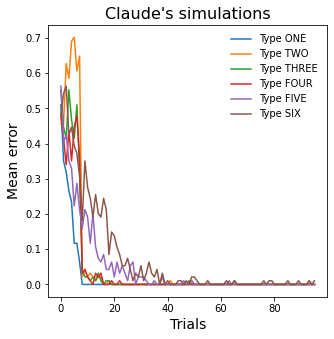

In [10]:
plt.figure(figsize=(5,5))
for cond in range(datas.condition.nunique()):
    plt.plot(1-correct[cond].mean(0), label = ["Type ONE", "Type TWO", "Type THREE", "Type FOUR", "Type FIVE", "Type SIX"][cond])
plt.title("Claude's simulations", fontsize=16)
plt.xlabel("Trials", fontsize=14)
plt.ylabel("Mean error", fontsize=14)
plt.legend(frameon=False)#, fontsize=14)
plt.show()

mean error for type 0: 0.020611702127659576
mean error for type 1: 0.052194148936170214
mean error for type 2: 0.040447695035460994
mean error for type 3: 0.03679078014184397
mean error for type 4: 0.048204787234042555
mean error for type 5: 0.07524379432624112


/u/ajagadish/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning: Columns (14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


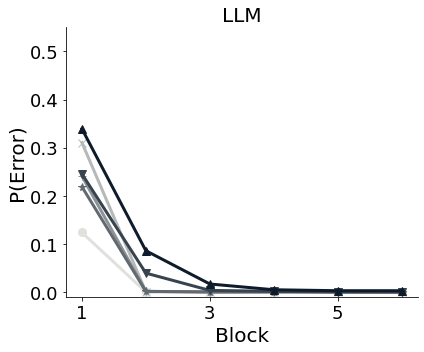

In [11]:
import seaborn as sns
# datas = pd.read_csv('../categorisation/data/human/badham2017deficitsllm_choiceshuman_allparticipants.csv')
datas = pd.read_csv('../categorisation/data/llm/shepard1961_llm_choices_match_ermi.csv')
models = ['LLM']
FONTSIZE=20
f, axes = plt.subplots(1, len(models), figsize=(6*len(models), 5))
colors = ['#E0E1DD', '#B6B9B9', '#8C9295', '#616A72','#37434E','#0D1B2A']
# markers for the six types of rules in the plot: circle, cross, plus, inverted triangle, asterisk, triangle
markers = ['o', 'x', '+', '*', 'v', '^']
num_blocks = 6
for idx, ax in enumerate([axes]):

    for cond in range(datas.condition.nunique()):
        mean_cond = 1-correct[cond].mean(0).reshape(96//16, 16).mean(1) #+ 0.1
        std_cond = correct[cond].std(0).reshape(96//16, 16).mean(1)/np.sqrt(num_participants)
        ax.plot(np.arange(96//16)+1, mean_cond, label=f'Type {cond}', lw=3, color=colors[cond], marker=markers[cond], markersize=8)
        print(f'mean error for type {cond}: {mean_cond.mean()}')   
    if idx==0:
        ax.set_title('LLM', fontsize=FONTSIZE)

    ax.set_xticks(np.arange(1, num_blocks+1))
    if idx==0:
        ax.set_xlabel('Block', fontsize=FONTSIZE)
        ax.set_ylabel('P(Error)', fontsize=FONTSIZE)
    ax.set_ylim([-0.01, .55])
    # locs, labels = ax.get_xticks(), ax.get_xticklabels()
    # Set new x-tick locations and labels
    ax.set_xticks(np.arange(1, num_blocks+1)[::2])
    ax.set_xticklabels(np.arange(1, num_blocks+1)[::2], fontsize=FONTSIZE-2)
    ax.tick_params(axis='y', labelsize=FONTSIZE-2)       

# add legend that spans across all subplots, in one row, at the center for the subplots, and place it outside the plot 
# f.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=6, fontsize=FONTSIZE-2, frameon=False, labels=[f'TYPE {task}' for task in tasks])
sns.despine()
f.tight_layout()
plt.show()

## smith and tassk

In [7]:
datas = pd.read_csv('../categorisation/data/human/devraj2022rationalllm_choiceshuman.csv')
# find the unique true_category in each participant 
unique_categories = datas.groupby('participant')['true_category'].unique()
# print(unique_categories)
for participant_id in datas.participant.unique()[:16]:
    datas.loc[datas.participant==participant_id, 'true_category'] = datas.loc[datas.participant==participant_id, 'true_category'].map({unique_categories[participant_id][0]: 0, unique_categories[participant_id][1]: 1})
    datas.loc[datas.participant==participant_id, 'llm_category'] = datas.loc[datas.participant==participant_id, 'llm_category'].map({unique_categories[participant_id][0]: 0, unique_categories[participant_id][1]: 1})
# datas

<ipython-input-7-7cfd7d3423dd>:1: DtypeWarning: Columns (23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  datas = pd.read_csv('../categorisation/data/human/devraj2022rationalllm_choiceshuman.csv')


In [38]:
datas

,participant,task,trial,choice,correct_choice,block,trial_segment,condition,category,all_features,...,feature6,stimulus_id,prototype_feature1,prototype_feature2,prototype_feature3,prototype_feature4,prototype_feature5,prototype_feature6,llm_category,true_category
0,0,0,0,1,0,0,0,control,1,"[1, 0, 0, 0, 0, 0]",...,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
1,0,0,1,1,0,0,0,control,1,"[0, 1, 0, 0, 0, 0]",...,0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
2,0,0,2,0,0,0,0,control,1,"[0, 0, 0, 0, 0, 1]",...,1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
3,0,0,3,0,1,0,0,control,2,"[1, 1, 0, 1, 1, 1]",...,1,10.0,1.0,1.0,1.0,1.0,1.0,1.0,0,1
4,0,0,4,1,0,0,0,control,1,"[1, 1, 1, 1, 0, 1]",...,1,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73915,119,0,611,1,1,43,10,experimental,2,"[1, 1, 1, 1, 1, 1]",...,1,7.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN
73916,119,0,612,1,1,43,10,experimental,2,"[1, 1, 1, 1, 1, 1]",...,1,7.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN
73917,119,0,613,1,1,43,10,experimental,2,"[1, 1, 0, 1, 1, 1]",...,1,10.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN
73918,119,0,614,1,1,43,10,experimental,2,"[1, 1, 0, 1, 1, 1]",...,1,10.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN


In [39]:
num_participants = 16 #datas.participant.max()
correct = np.ones((1, num_participants, 616))
human_correct = np.ones((1, num_participants, 616))

for participant_id  in range(num_participants):#= 4
    for cond in ['control']: #datas.condition.nunique()):
        data = datas[datas.condition==cond]
        correct_trials = data[data.participant==participant_id].llm_category.values==data[data.participant==participant_id].true_category.values
        correct[0, participant_id, :len(correct_trials)] = correct_trials
        
        human_correct_trials = data[data.participant==participant_id].choice.values==data[data.participant==participant_id].correct_choice.values
        human_correct[0, participant_id,:len(correct_trials)] = human_correct_trials
        #plt.plot(data[data.participant==participant_id].llm_category.values==data[data.participant==participant_id].true_category.values)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


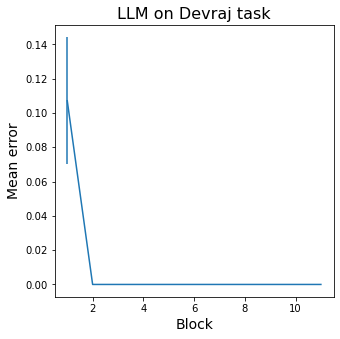

In [41]:
plt.figure(figsize=(5,5))
# for cond in range(datas.condition.nunique()):
#     plt.plot(1-correct[0].mean(0))
mean_cond = 1-correct[0].mean(0).reshape(616//56, 56).mean(1)
std_cond = correct[0].std(0).reshape(616//56, 56).mean(1)/np.sqrt(num_participants)
plt.errorbar(np.arange(616//56)+1, mean_cond, yerr=std_cond)
plt.title("LLM on Devraj task", fontsize=16)
plt.xlabel("Block", fontsize=14)
plt.ylabel("Mean error", fontsize=14)
plt.legend(frameon=False)#, fontsize=14)
plt.show()

## four rules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
datas = pd.read_csv('../categorisation/data/llm/badham2017deficits_llm_choicesmatch_ermi.csv')

In [2]:
categories = {'j': 'A', 'f': 'B'}
datas['human_category']=datas['choice'].map(categories)

In [3]:
num_participants = 94
correct = np.ones((4, num_participants, 96))
human_correct = np.ones((4, num_participants, 96))

for participant_id  in range(num_participants):#= 4
    for cond in datas.condition.unique(): #datas.condition.nunique()):
        data = datas[datas.condition==cond]
        correct_trials = data[data.participant==participant_id].llm_category.values==data[data.participant==participant_id].true_category.values
        correct[cond-1, participant_id, :len(correct_trials)] = correct_trials
        human_correct_trials = data[data.participant==participant_id].choice.values==data[data.participant==participant_id].correct_choice.values
        human_correct[cond-1, participant_id,:len(correct_trials)] = human_correct_trials

In [4]:
data

,participant,task,trial,choice,correct_choice,reward,block,condition,category,object,all_features,feature1,feature2,feature3,llm_category,true_category,human_category
288,0,0,288,j,j,1.0,3,4,1,Small White Triangle,"[0, 0, 0]",0,0,0,C,C,A
289,0,0,289,f,j,-1.0,3,4,1,Small Black Triangle,"[0, 1, 0]",0,1,0,C,C,B
290,0,0,290,j,f,-1.0,3,4,0,Big White Triangle,"[1, 0, 0]",1,0,0,Z,Z,A
291,0,0,291,j,j,1.0,3,4,1,Big Black Triangle,"[1, 1, 0]",1,1,0,Z,C,A
292,0,0,292,j,j,1.0,3,4,1,Small Black Square,"[0, 1, 1]",0,1,1,C,C,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33195,94,0,91,f,j,-1.0,0,4,1,Small White Triangle,"[0, 0, 0]",0,0,0,A,A,B
33196,94,0,92,f,f,1.0,0,4,0,Small White Square,"[0, 0, 1]",0,0,1,Q,Q,B
33197,94,0,93,j,j,1.0,0,4,1,Small White Triangle,"[0, 0, 0]",0,0,0,A,A,A
33198,94,0,94,f,f,1.0,0,4,0,Small Black Square,"[0, 1, 1]",0,1,1,Q,Q,B


In [ ]:
#

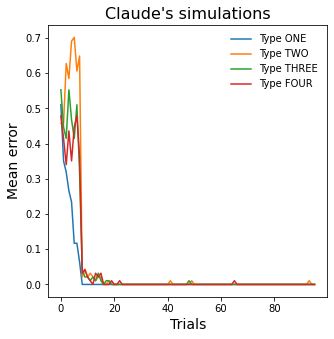

In [7]:
plt.figure(figsize=(5,5))
for cond in range(datas.condition.nunique()):
    plt.plot(1-correct[cond].mean(0), label = ["Type ONE", "Type TWO", "Type THREE", "Type FOUR"][cond])
plt.title("Claude's simulations", fontsize=16)
plt.xlabel("Trials", fontsize=14)
plt.ylabel("Mean error", fontsize=14)
plt.legend(frameon=False)#, fontsize=14)
plt.show()

In [8]:
correct.shape

(4, 94, 96)

In [9]:
correct[cond].mean(0).reshape(96//16, 16).shape

(6, 16)

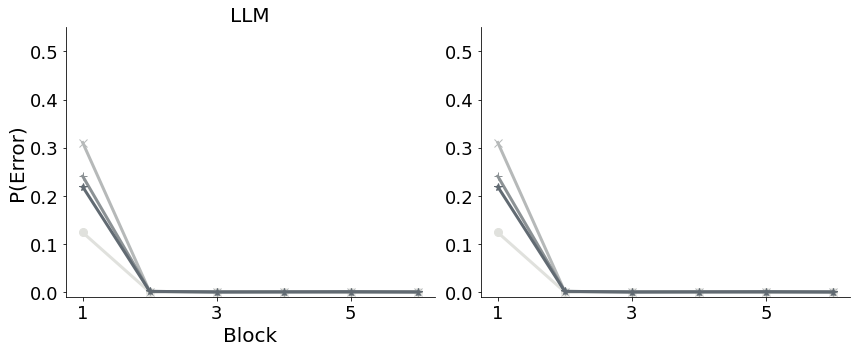

In [10]:
import seaborn as sns
models = ['LLM', None]
FONTSIZE=20
f, axes = plt.subplots(1, len(models), figsize=(6*len(models), 5))
colors = ['#E0E1DD', '#B6B9B9', '#8C9295', '#616A72','#37434E','#0D1B2A']
# markers for the six types of rules in the plot: circle, cross, plus, inverted triangle, asterisk, triangle
markers = ['o', 'x', '+', '*', 'v', '^']
num_blocks = 6
for idx, ax in enumerate(axes):

    for cond in range(datas.condition.nunique()):
        mean_cond = 1-correct[cond].mean(0).reshape(96//16, 16).mean(1)
        std_cond = correct[cond].std(0).reshape(96//16, 16).mean(1)/np.sqrt(num_participants)
        ax.plot(np.arange(96//16)+1, mean_cond, label=f'Type {cond}', lw=3, color=colors[cond], marker=markers[cond], markersize=8)

    if idx==0:
        ax.set_title('LLM', fontsize=FONTSIZE)

    ax.set_xticks(np.arange(1, num_blocks+1))
    if idx==0:
        ax.set_xlabel('Block', fontsize=FONTSIZE)
        ax.set_ylabel('P(Error)', fontsize=FONTSIZE)
    ax.set_ylim([-0.01, .55])
    # locs, labels = ax.get_xticks(), ax.get_xticklabels()
    # Set new x-tick locations and labels
    ax.set_xticks(np.arange(1, num_blocks+1)[::2])
    ax.set_xticklabels(np.arange(1, num_blocks+1)[::2], fontsize=FONTSIZE-2)
    ax.tick_params(axis='y', labelsize=FONTSIZE-2)       

# add legend that spans across all subplots, in one row, at the center for the subplots, and place it outside the plot 
# f.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=6, fontsize=FONTSIZE-2, frameon=False, labels=[f'TYPE {task}' for task in tasks])
sns.despine()
f.tight_layout()
plt.show()

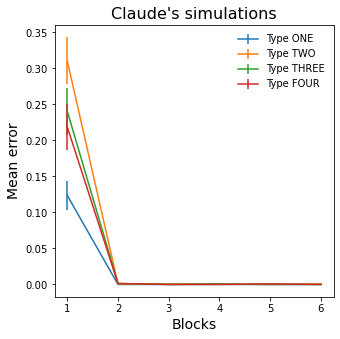

In [123]:
plt.figure(figsize=(5,5))
for cond in range(datas.condition.nunique()):
    mean_cond = 1-correct[cond].mean(0).reshape(96//16, 16).mean(1)
    std_cond = correct[cond].std(0).reshape(96//16, 16).mean(1)/np.sqrt(num_participants)
    plt.errorbar(np.arange(96//16)+1, mean_cond, yerr=std_cond, label = ["Type ONE", "Type TWO", "Type THREE", "Type FOUR"][cond])
plt.title("Claude's simulations", fontsize=16)
plt.xlabel("Blocks", fontsize=14)
plt.ylabel("Mean error", fontsize=14)
plt.legend(frameon=False)#, fontsize=14)
plt.show()

<Axes: xlabel='trial'>

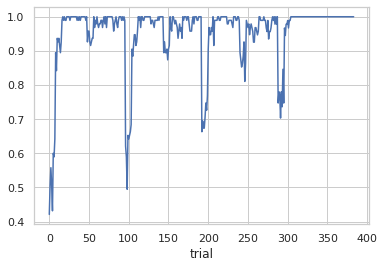

In [62]:
# add a new column to the dataframe when llm_category is same as true_category
data['correct'] = data['llm_category'] == data['true_category']
# plot correct averaged over participants for condition == 1 over time
data.groupby('trial')['correct'].mean().plot()



In [6]:
import numpy as np

In [7]:
data[data.participant.isin(data.participant.unique())]#==data[data.participant.isin(data.participant.unique())].true_category.values # ==data[data.participant.isin(data.participant.unique())].true_category.values

,participant,task,trial,choice,correct_choice,reward,block,condition,category,object,all_features,feature1,feature2,feature3,llm_category,true_category
0,0,0,0,j,j,1.0,0,1,1,Big Black Square,"[1, 1, 1]",1,1,1,Y,Y
1,0,0,1,j,f,-1.0,0,1,0,Small Black Triangle,"[0, 1, 0]",0,1,0,E,E
2,0,0,2,f,j,-1.0,0,1,1,Big White Triangle,"[1, 0, 0]",1,0,0,Y,Y
3,0,0,3,f,f,1.0,0,1,0,Small White Triangle,"[0, 0, 0]",0,0,0,E,E
4,0,0,4,f,f,1.0,0,1,0,Small White Square,"[0, 0, 1]",0,0,1,E,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33435,94,0,331,f,f,1.0,3,1,0,Big White Triangle,"[1, 0, 0]",1,0,0,B,B
33436,94,0,332,j,j,1.0,3,1,1,Small Black Triangle,"[0, 1, 0]",0,1,0,J,J
33437,94,0,333,j,j,1.0,3,1,1,Small Black Square,"[0, 1, 1]",0,1,1,J,J
33438,94,0,334,f,f,1.0,3,1,0,Small White Triangle,"[0, 0, 0]",0,0,0,B,B


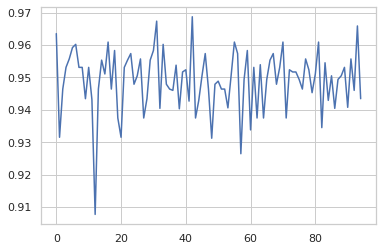

In [35]:
import matplotlib.pyplot as plt
plt.plot(df_grouped.accuracy[:])

In [ ]:
# dat

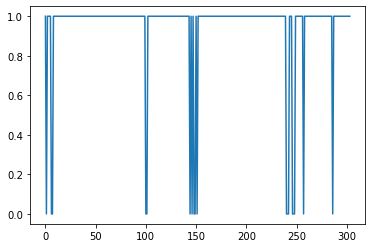

In [65]:
participant_id = 90
num_trials = 400
plt.plot((data[data.participant==participant_id].llm_category.values==data[data.participant==participant_id].true_category.values)[:num_trials])

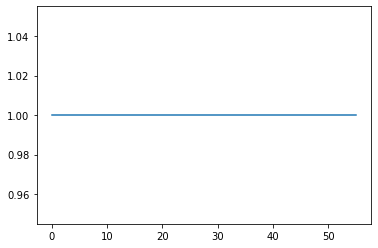

In [66]:
import matplotlib.pyplot as plt
plt.plot(data[data.participant==0].llm_category[:56].values==data[data.participant==0].true_category[:56].values)